In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import re
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
import nltk
nltk.download('stopwords')
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from pandas.io.json import json_normalize
import random
from Data_Processor import Data_Processor

init_notebook_mode(connected=True) #do not miss this line
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunzehui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def datelist(start_month, end_month):
    start_year = int(start_month[:4])
    start_month = int(start_month[-2:])
    end_year = int(end_month[:4])
    end_month = int(end_month[-2:])
    if start_year == end_year:
        month_range = range(start_month, end_month + 1)
        date_list = ["{year}-{month:0=2d}".format(year=str(start_year), month=M) for M in month_range]
        return date_list
    year_range = range(start_year + 1, end_year)
    start_year_month_range = range(start_month, 13)
    end_year_month_range = range(1, end_month + 1)
    date_list = ["{year}-{month:0=2d}".format(year=str(start_year), month=M) for M in start_year_month_range]
    date_list += ["{year}-{month:0=2d}".format(year=str(Y), month=M) for Y in year_range for M in range(1, 13)]
    date_list += ["{year}-{month:0=2d}".format(year=str(end_year), month=M) for M in end_year_month_range]
    return date_list

# Discount Brokerage

## Overview

In [83]:
start_month='2017-06'
end_month='2020-05'
DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/Charles Schwab/CharlesSchwab",
                            "result0623/Discount Brokerage/eTrade/eTrade",
                            "result0623/Discount Brokerage/Fidelity/FidelityInvestments",
                            "result0623/Discount Brokerage/TD Ameritrade/TDAmeritrade",
                            "result0623/Discount Brokerage/Vanguard/Vanguard"])
DP.readdata()
print(DP.datanums())

([8244, 7383, 8565, 7733, 8527, 10010, 8443, 8880, 10070, 9479, 11656, 9648, 10558, 9045, 8738, 9767, 10504, 9255, 9655, 9630, 8927, 9072, 10421, 11216, 11290, 9656, 9816, 8639, 13980, 12473, 10301, 11458, 12377, 16412, 14251, 14104], 370183)


In [84]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_db = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_db = scores_month_db.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [85]:
score_dist_db = df["label"].value_counts().to_frame()
score_dist_db.columns = ["count"]
score_dist_db = score_dist_db.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_db["index"],
               y = score_dist_db["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

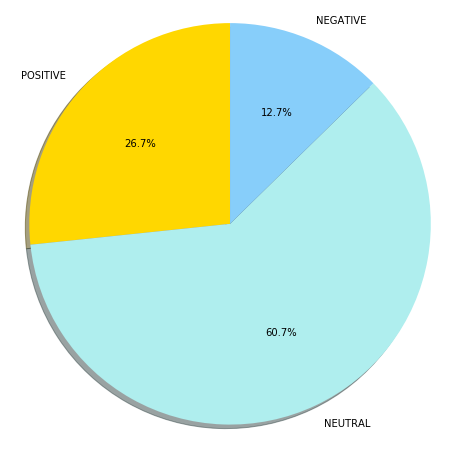

In [86]:
colors = ['gold','paleturquoise','lightskyblue']
labels_db = list(score_dist_db['index'].values)
sizes_db = list(score_dist_db['count'].values/sum(score_dist_db['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_db, labels=labels_db, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

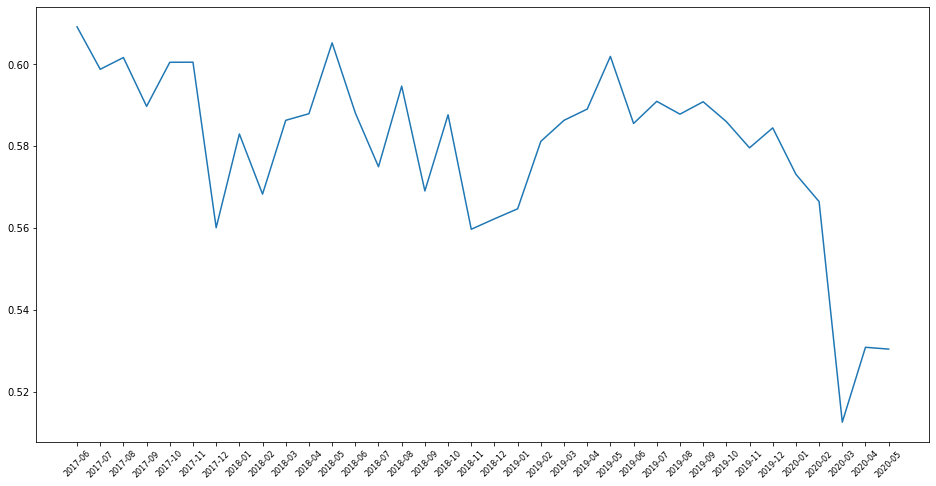

In [87]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_db['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

## Each Company

### Charles Schwab

In [103]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/Charles Schwab/CharlesSchwab"])
DP.readdata()
print(DP.datanums())

([725, 890, 801, 901, 1109, 1390, 1032, 1067, 1088, 1134, 2435, 1469, 1178, 1084, 976, 1259, 1625, 1218, 929, 957, 1218, 1085, 1664, 2457, 2022, 1355, 1052, 1167, 2977, 2445, 1571, 1281, 1767, 1869, 2006, 1870], 51073)


In [104]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_cs = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_cs = scores_month_cs.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [105]:
score_dist_cs = df["label"].value_counts().to_frame()
score_dist_cs.columns = ["count"]
score_dist_cs = score_dist_cs.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_cs["index"],
               y = score_dist_cs["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

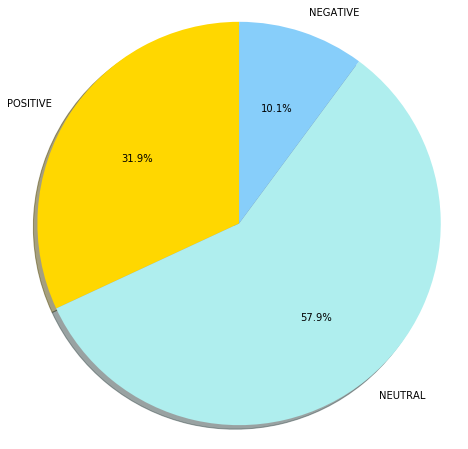

In [106]:
colors = ['gold','paleturquoise','lightskyblue']
labels_cs = list(score_dist_cs['index'].values)
sizes_cs = list(score_dist_cs['count'].values/sum(score_dist_cs['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_cs, labels=labels_cs, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

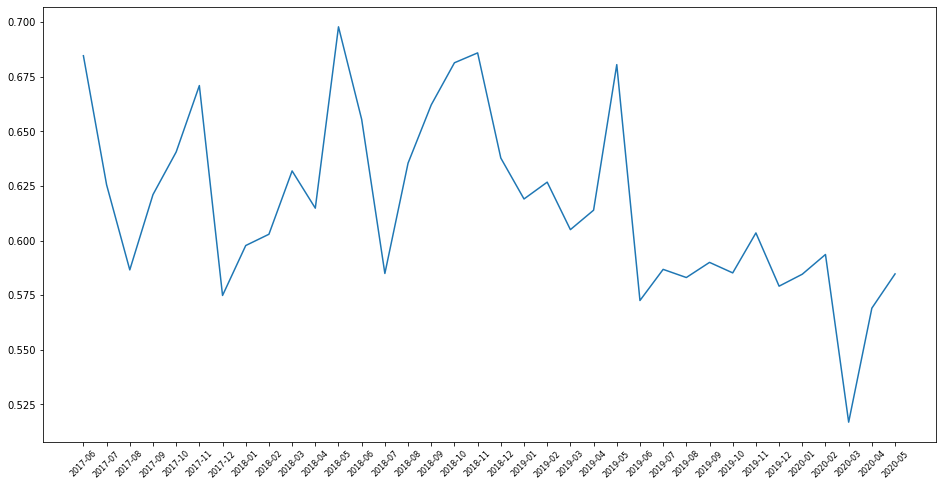

In [107]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_cs['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### eTrade

In [55]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/eTrade/eTrade"])
DP.readdata()
print(DP.datanums())

([1435, 1351, 1533, 1642, 1527, 3120, 1592, 2052, 2364, 1600, 2645, 1364, 1350, 1235, 1134, 1217, 1285, 1371, 1576, 1603, 1229, 1488, 1893, 1907, 1551, 1440, 1824, 1253, 2730, 1601, 1265, 1846, 2536, 4602, 2844, 3278], 66283)


In [56]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_et = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_et = scores_month_et.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [57]:
score_dist_et = df["label"].value_counts().to_frame()
score_dist_et.columns = ["count"]
score_dist_et = score_dist_et.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_et["index"],
               y = score_dist_et["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

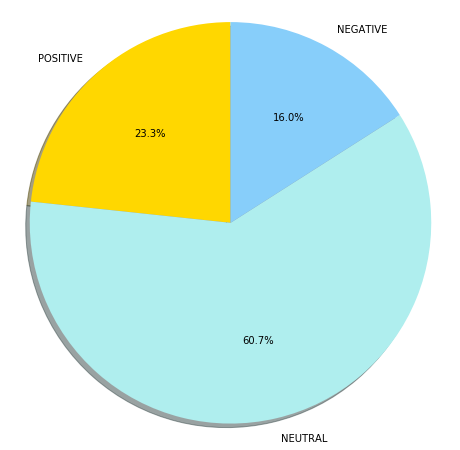

In [58]:
colors = ['gold','paleturquoise','lightskyblue']
labels_et = list(score_dist_et['index'].values)
sizes_et = list(score_dist_et['count'].values/sum(score_dist_et['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_et, labels=labels_et, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

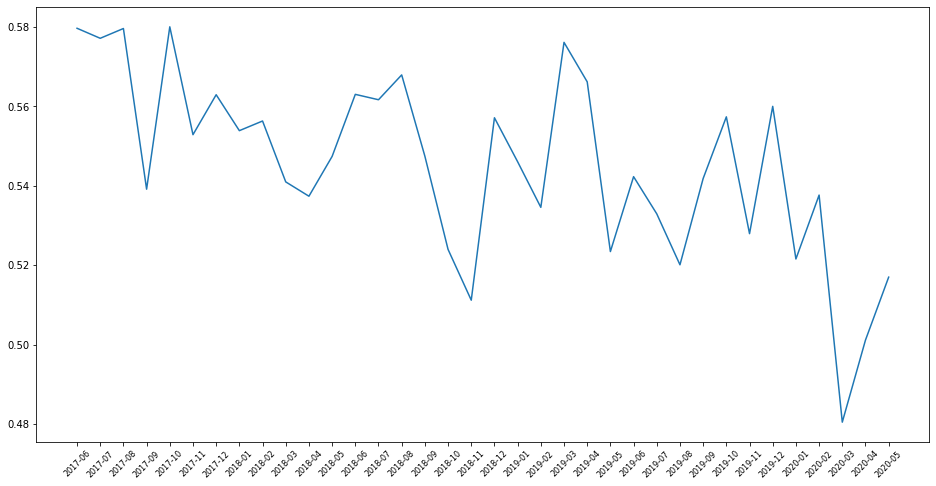

In [59]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_et['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Fidelity

In [60]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/Fidelity/FidelityInvestments"])
DP.readdata()
print(DP.datanums())

([143, 159, 217, 171, 273, 194, 227, 237, 328, 333, 267, 280, 335, 241, 289, 415, 503, 235, 285, 473, 445, 335, 289, 565, 275, 244, 323, 364, 534, 446, 356, 377, 392, 280, 309, 234], 11373)


In [61]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_fi = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_fi = scores_month_fi.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [62]:
score_dist_fi = df["label"].value_counts().to_frame()
score_dist_fi.columns = ["count"]
score_dist_fi = score_dist_fi.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_fi["index"],
               y = score_dist_fi["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

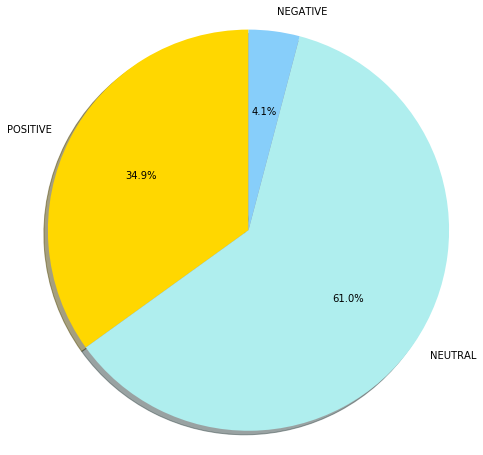

In [63]:
colors = ['gold','paleturquoise','lightskyblue']
labels_fi = list(score_dist_fi['index'].values)
sizes_fi = list(score_dist_fi['count'].values/sum(score_dist_fi['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_fi, labels=labels_fi, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

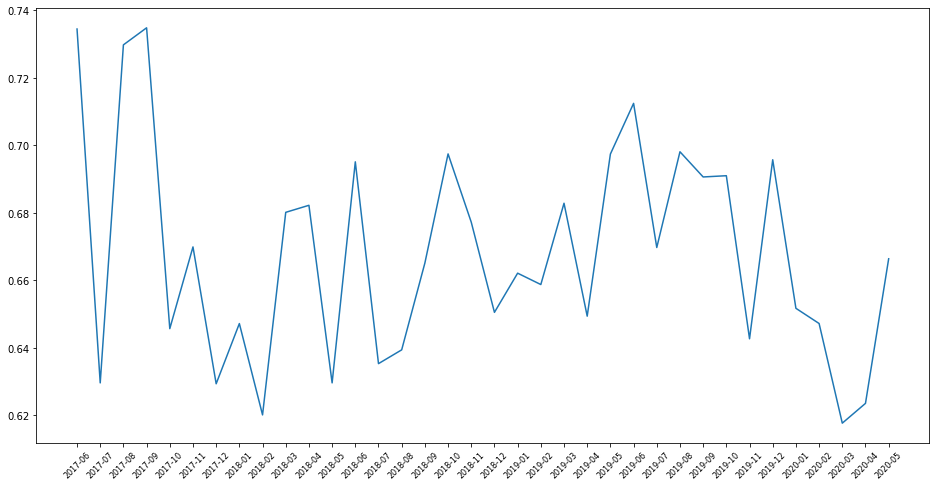

In [64]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_fi['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### TD Ameritrade

In [78]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/TD Ameritrade/TDAmeritrade"])
DP.readdata()
print(DP.datanums())

([2699, 1204, 2008, 1298, 1763, 1323, 2188, 2028, 2768, 2362, 2018, 1810, 2895, 1518, 1727, 2059, 2506, 1614, 2378, 2037, 1725, 1859, 2535, 2425, 3029, 1892, 1872, 1630, 2777, 2705, 1987, 2543, 2469, 4650, 3531, 3691], 81523)


In [79]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_td = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_td = scores_month_td.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [80]:
score_dist_td = df["label"].value_counts().to_frame()
score_dist_td.columns = ["count"]
score_dist_td = score_dist_td.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_td["index"],
               y = score_dist_td["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

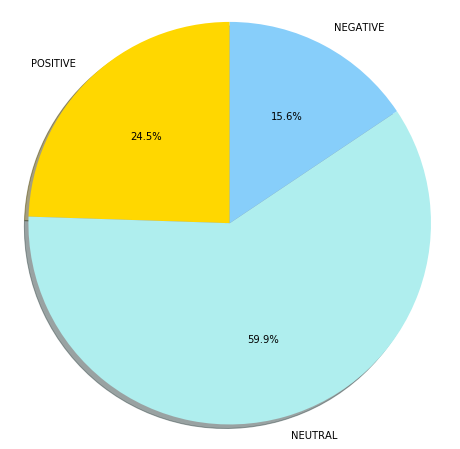

In [81]:
colors = ['gold','paleturquoise','lightskyblue']
labels_td = list(score_dist_td['index'].values)
sizes_td = list(score_dist_td['count'].values/sum(score_dist_td['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_td, labels=labels_td, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

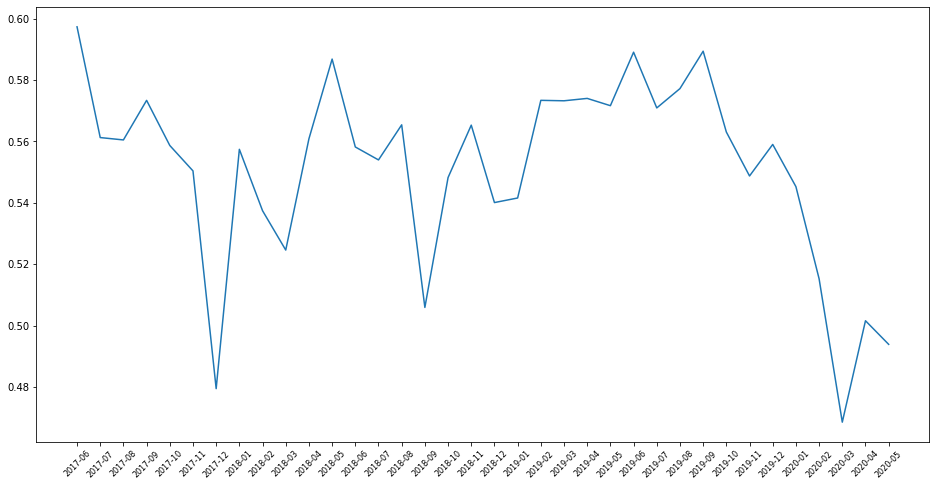

In [82]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_td['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Vanguard

In [65]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Discount Brokerage/Vanguard/Vanguard"])
DP.readdata()
print(DP.datanums())

([3242, 3779, 4006, 3721, 3855, 3983, 3404, 3496, 3522, 4050, 4291, 4725, 4800, 4967, 4612, 4817, 4585, 4817, 4487, 4560, 4310, 4305, 4040, 3862, 4413, 4725, 4745, 4225, 4962, 5276, 5122, 5411, 5213, 5011, 5561, 5031], 159931)


In [66]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_va = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_va = scores_month_va.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [67]:
score_dist_va = df["label"].value_counts().to_frame()
score_dist_va.columns = ["count"]
score_dist_va = score_dist_va.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_va["index"],
               y = score_dist_va["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

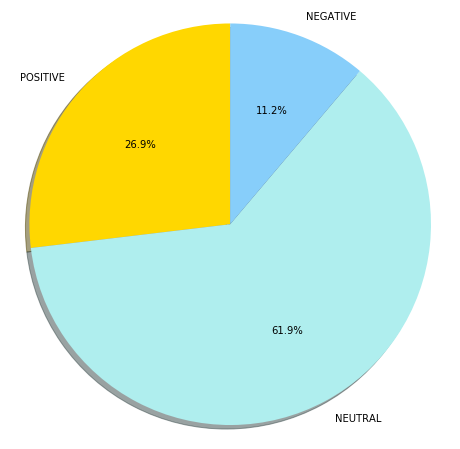

In [108]:
colors = ['gold','paleturquoise','lightskyblue']
labels_va = list(score_dist_va['index'].values)
sizes_va = list(score_dist_va['count'].values/sum(score_dist_va['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_va, labels=labels_va, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

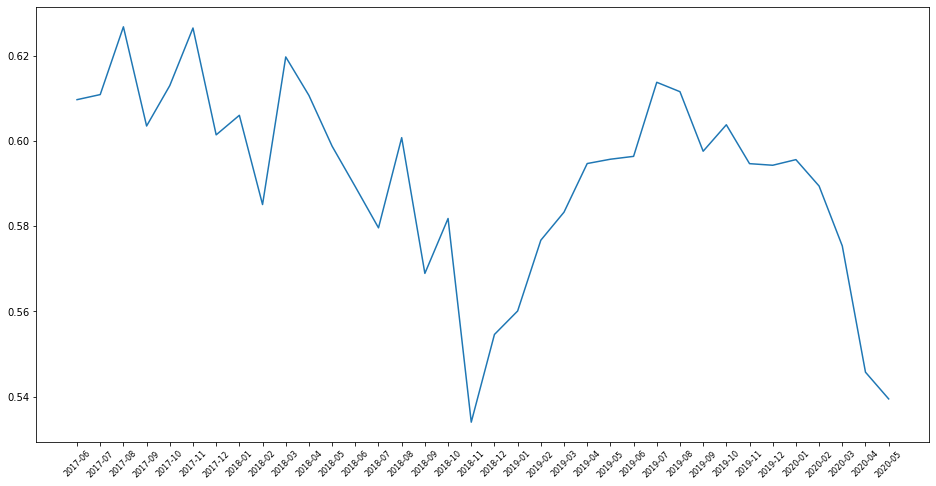

In [109]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_va['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Comparasion

<function matplotlib.pyplot.show(*args, **kw)>

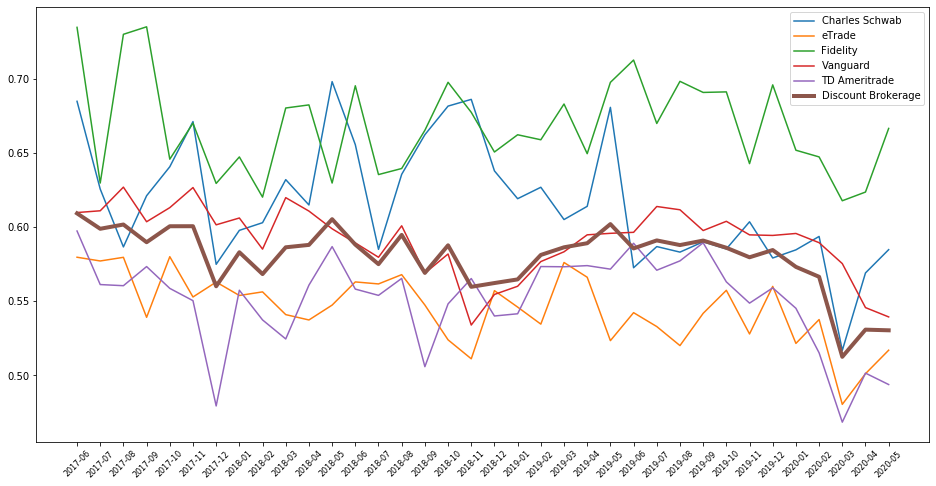

In [110]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_cs['avg_score'], label = 'Charles Schwab')
plt.plot(scores_month_et['avg_score'], label = 'eTrade')
plt.plot(scores_month_fi['avg_score'], label = 'Fidelity')
plt.plot(scores_month_va['avg_score'], label = 'Vanguard')
plt.plot(scores_month_td['avg_score'], label = 'TD Ameritrade')
plt.plot(scores_month_db['avg_score'], label = 'Discount Brokerage',linewidth=4)
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.legend()
plt.show

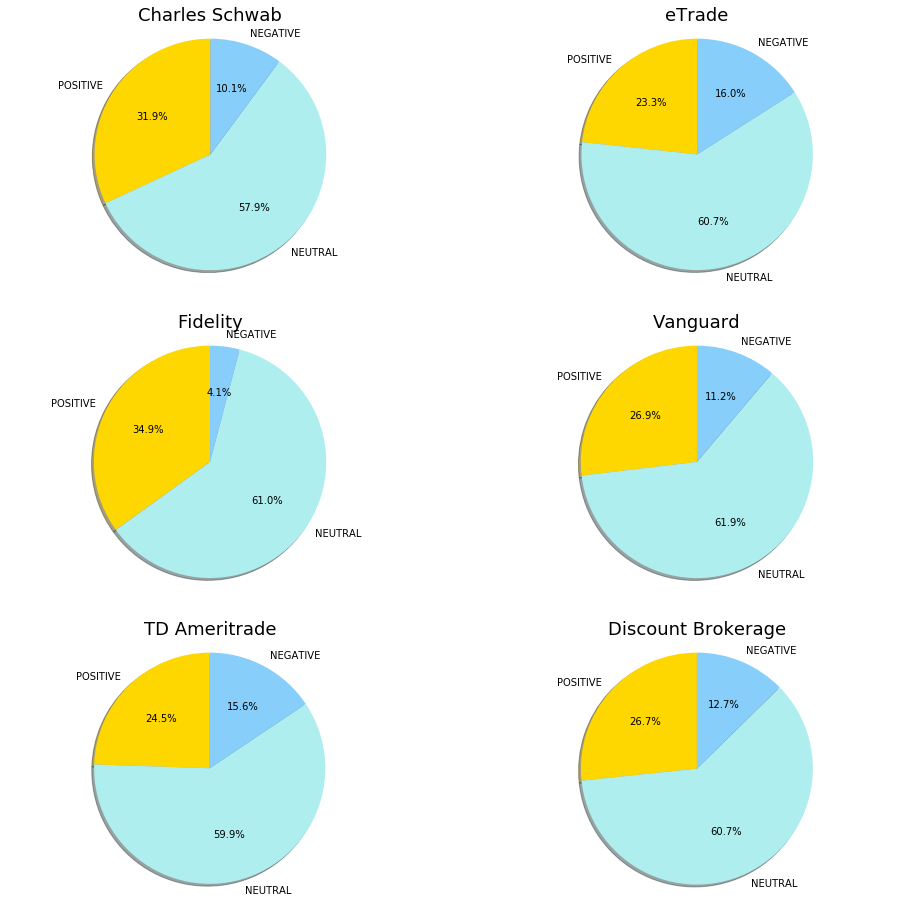

In [111]:
colors = ['gold','paleturquoise','lightskyblue']
fig, axs = plt.subplots(3, 2,figsize=(16,16))

axs[0,0].pie(sizes_cs, labels=labels_cs, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,0].axis('equal') 
axs[0,0].set_title("Charles Schwab",fontsize = 18)

axs[0,1].pie(sizes_et, labels=labels_et, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,1].axis('equal') 
axs[0,1].set_title("eTrade",fontsize = 18)

axs[1,0].pie(sizes_fi, labels=labels_fi, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,0].axis('equal') 
axs[1,0].set_title("Fidelity",fontsize = 18)

axs[1,1].pie(sizes_va, labels=labels_va, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,1].axis('equal') 
axs[1,1].set_title("Vanguard",fontsize = 18)

axs[2,0].pie(sizes_td, labels=labels_td, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[2,0].axis('equal') 
axs[2,0].set_title("TD Ameritrade",fontsize = 18)

axs[2,1].pie(sizes_db, labels=labels_db, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[2,1].axis('equal') 
axs[2,1].set_title("Discount Brokerage",fontsize = 18)

plt.show()

# Robo Advisor

## Overview

In [187]:
start_month='2017-06'
end_month='2020-05'
DP=Data_Processor(start_month, end_month,
                  template=["result0623/Robo Advisor/Betterment/Betterment",
                            "result0623/Robo Advisor/Personal Capital/PersonalCapital",
                            "result0623/Robo Advisor/Robo/Robo",
                            "result0623/Robo Advisor/wealthfront/Wealthfront"])
DP.readdata()
print(DP.datanums())
DP.clean()
print(DP.datanums())

([2386, 2485, 2491, 2457, 2401, 2376, 2101, 2701, 3216, 2445, 1963, 1888, 1731, 1818, 1710, 1505, 2035, 1464, 1998, 1418, 1582, 1694, 1550, 1283, 1709, 1887, 1756, 1569, 1711, 1496, 1772, 1677, 1724, 1836, 1602, 1549], 68986)
([2386, 2485, 2491, 2457, 2401, 2376, 2101, 2701, 3216, 2445, 1963, 1888, 1731, 1818, 1710, 1505, 2035, 1464, 1998, 1418, 1582, 1694, 1550, 1283, 1709, 1887, 1756, 1569, 1711, 1496, 1772, 1677, 1724, 1836, 1602, 1549], 68986)


In [92]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_ra = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_ra = scores_month_ra.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [93]:
score_dist_ra = df["label"].value_counts().to_frame()
score_dist_ra.columns = ["count"]
score_dist_ra = score_dist_ra.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_ra["index"],
               y = score_dist_ra["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

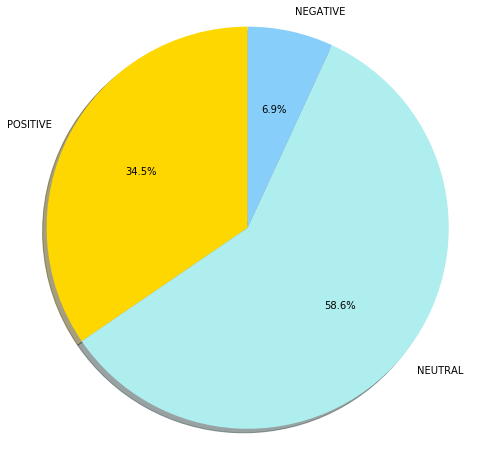

In [96]:
colors = ['gold','paleturquoise','lightskyblue']
labels_ra = list(score_dist_ra['index'].values)
sizes_ra = list(score_dist_ra['count'].values/sum(score_dist_ra['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_ra, labels=labels_ra, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

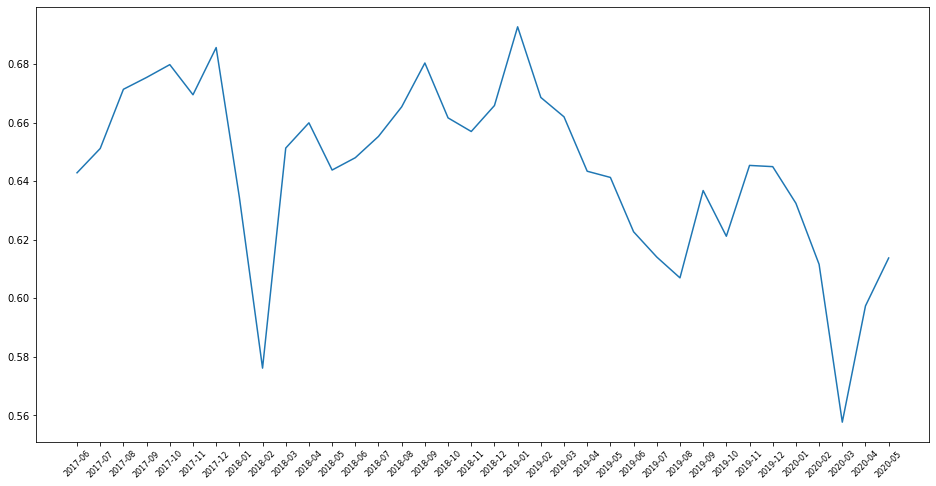

In [95]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_ra['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

## Each Company

### Betterment

In [97]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Robo Advisor/Betterment/Betterment"])
DP.readdata()
print(DP.datanums())

([4, 18, 14, 12, 6, 24, 4, 20, 16, 22, 20, 30, 34, 38, 26, 66, 20, 16, 14, 38, 12, 34, 50, 12, 28, 22, 34, 36, 38, 28, 18, 14, 24, 32, 22, 24], 870)


In [98]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_be = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_be = scores_month_be.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [99]:
score_dist_be = df["label"].value_counts().to_frame()
score_dist_be.columns = ["count"]
score_dist_be = score_dist_be.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_be["index"],
               y = score_dist_be["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

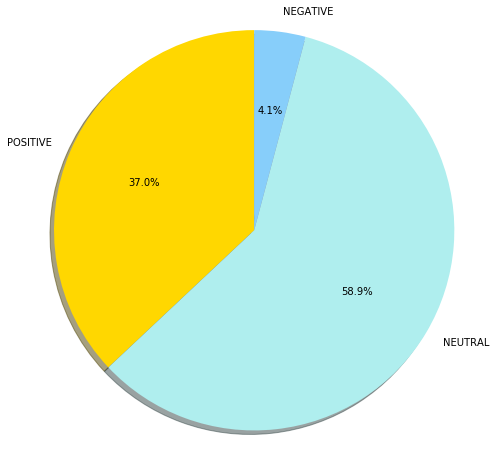

In [101]:
colors = ['gold','paleturquoise','lightskyblue']
labels_be = list(score_dist_be['index'].values)
sizes_be = list(score_dist_be['count'].values/sum(score_dist_be['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_be, labels=labels_be, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

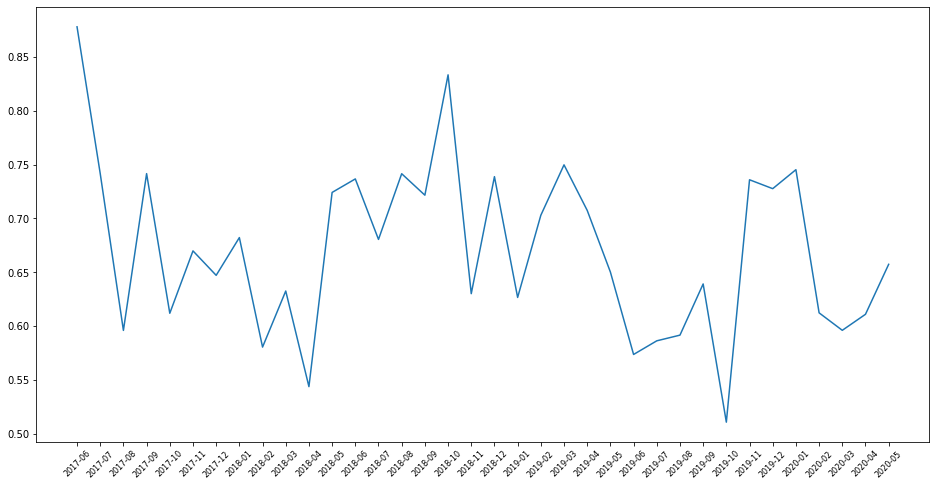

In [102]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_be['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Personal Capital

In [112]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Robo Advisor/Personal Capital/PersonalCapital"])
DP.readdata()
print(DP.datanums())

([343, 308, 440, 438, 330, 481, 442, 475, 485, 424, 511, 339, 445, 409, 415, 386, 400, 373, 413, 170, 435, 461, 459, 353, 469, 458, 458, 387, 578, 461, 446, 524, 573, 454, 496, 520], 15559)


In [113]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_pc = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_pc = scores_month_pc.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [114]:
score_dist_pc = df["label"].value_counts().to_frame()
score_dist_pc.columns = ["count"]
score_dist_pc = score_dist_pc.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_pc["index"],
               y = score_dist_pc["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

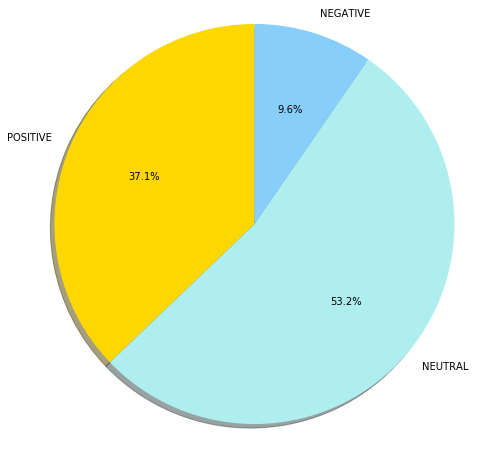

In [115]:
colors = ['gold','paleturquoise','lightskyblue']
labels_pc = list(score_dist_pc['index'].values)
sizes_pc = list(score_dist_pc['count'].values/sum(score_dist_pc['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_pc, labels=labels_pc, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

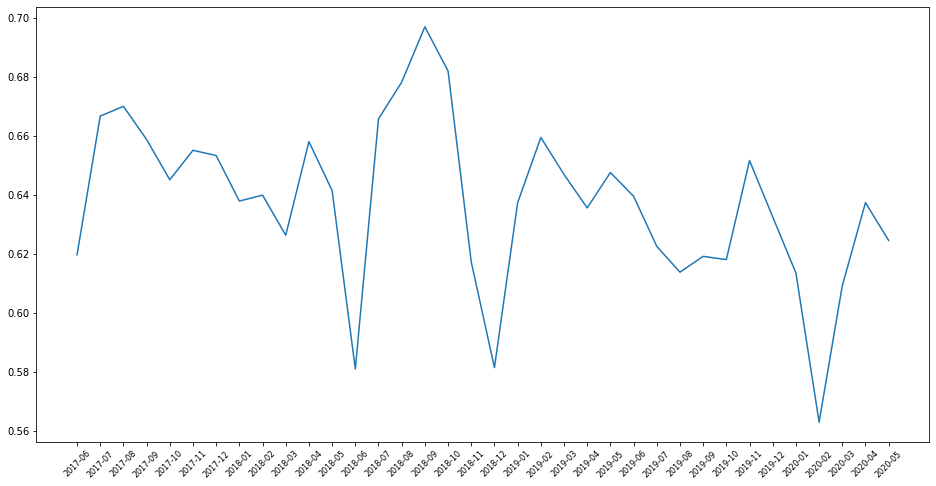

In [116]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_pc['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Robo

In [117]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Robo Advisor/Robo/Robo"])
DP.readdata()
print(DP.datanums())

([1247, 1441, 1609, 1644, 1483, 1373, 1246, 1528, 1823, 1268, 985, 877, 915, 941, 867, 776, 1024, 792, 751, 748, 621, 711, 531, 552, 676, 724, 626, 667, 680, 603, 540, 562, 579, 606, 534, 621], 33171)


In [118]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_ro = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_ro = scores_month_ro.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [119]:
score_dist_ro = df["label"].value_counts().to_frame()
score_dist_ro.columns = ["count"]
score_dist_ro = score_dist_ro.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_ro["index"],
               y = score_dist_ro["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

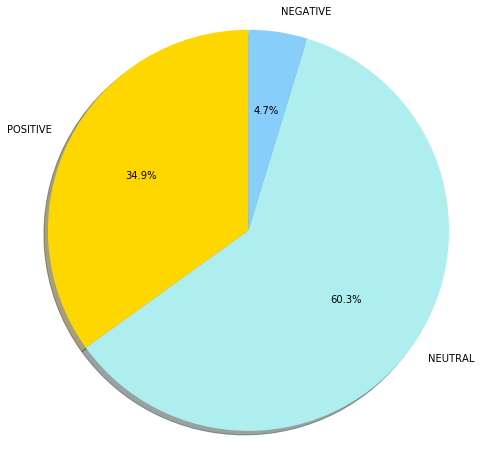

In [120]:
colors = ['gold','paleturquoise','lightskyblue']
labels_ro = list(score_dist_ro['index'].values)
sizes_ro = list(score_dist_ro['count'].values/sum(score_dist_ro['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_ro, labels=labels_ro, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

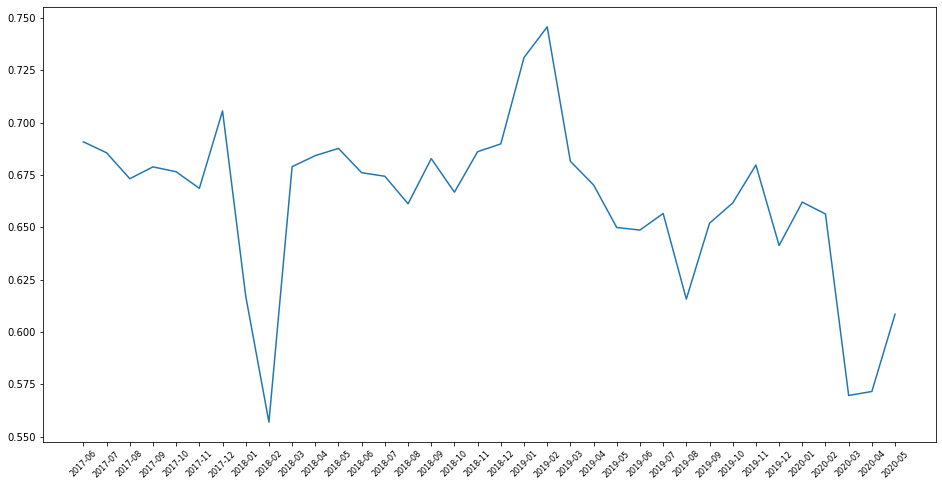

In [121]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_ro['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Wealthfront

In [122]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Robo Advisor/wealthfront/Wealthfront"])
DP.readdata()
print(DP.datanums())

([792, 718, 428, 363, 582, 498, 409, 678, 892, 731, 447, 642, 337, 430, 402, 277, 591, 283, 820, 462, 514, 488, 510, 366, 536, 683, 638, 479, 415, 404, 768, 577, 548, 744, 550, 384], 19386)


In [123]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_we = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_we = scores_month_we.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [124]:
score_dist_we = df["label"].value_counts().to_frame()
score_dist_we.columns = ["count"]
score_dist_we = score_dist_we.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_we["index"],
               y = score_dist_we["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

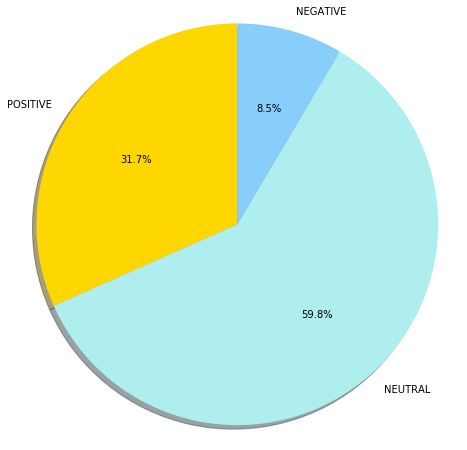

In [125]:
colors = ['gold','paleturquoise','lightskyblue']
labels_we = list(score_dist_we['index'].values)
sizes_we = list(score_dist_we['count'].values/sum(score_dist_we['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_we, labels=labels_we, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

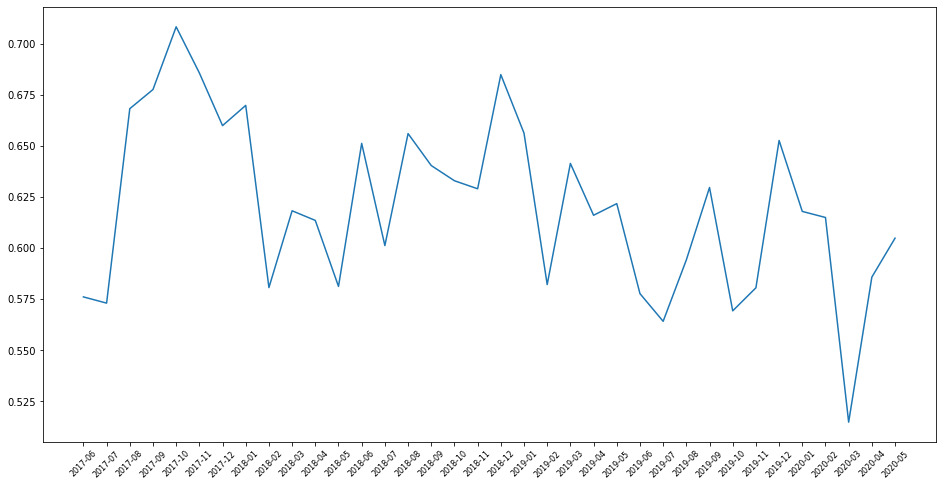

In [126]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_we['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Comparasion

<function matplotlib.pyplot.show(*args, **kw)>

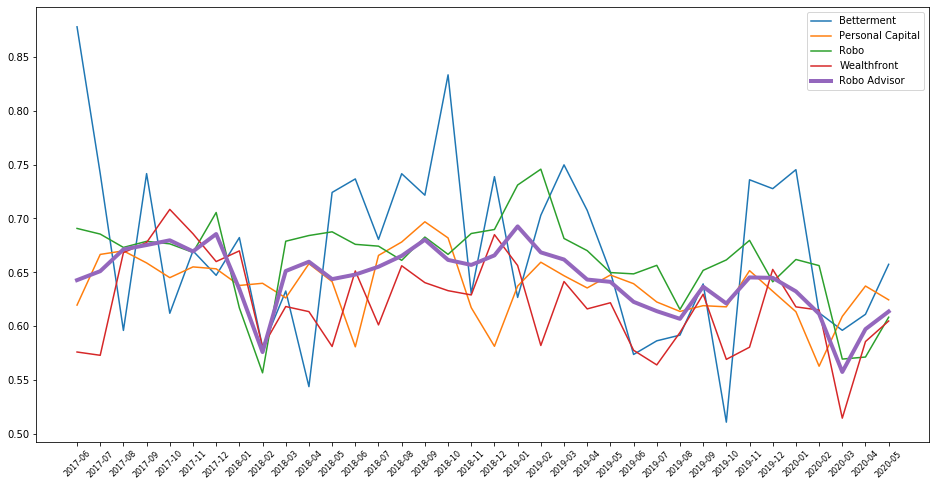

In [127]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_be['avg_score'], label = 'Betterment')
plt.plot(scores_month_pc['avg_score'], label = 'Personal Capital')
plt.plot(scores_month_ro['avg_score'], label = 'Robo')
plt.plot(scores_month_we['avg_score'], label = 'Wealthfront')
plt.plot(scores_month_ra['avg_score'], label = 'Robo Advisor',linewidth=4)
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.legend()
plt.show

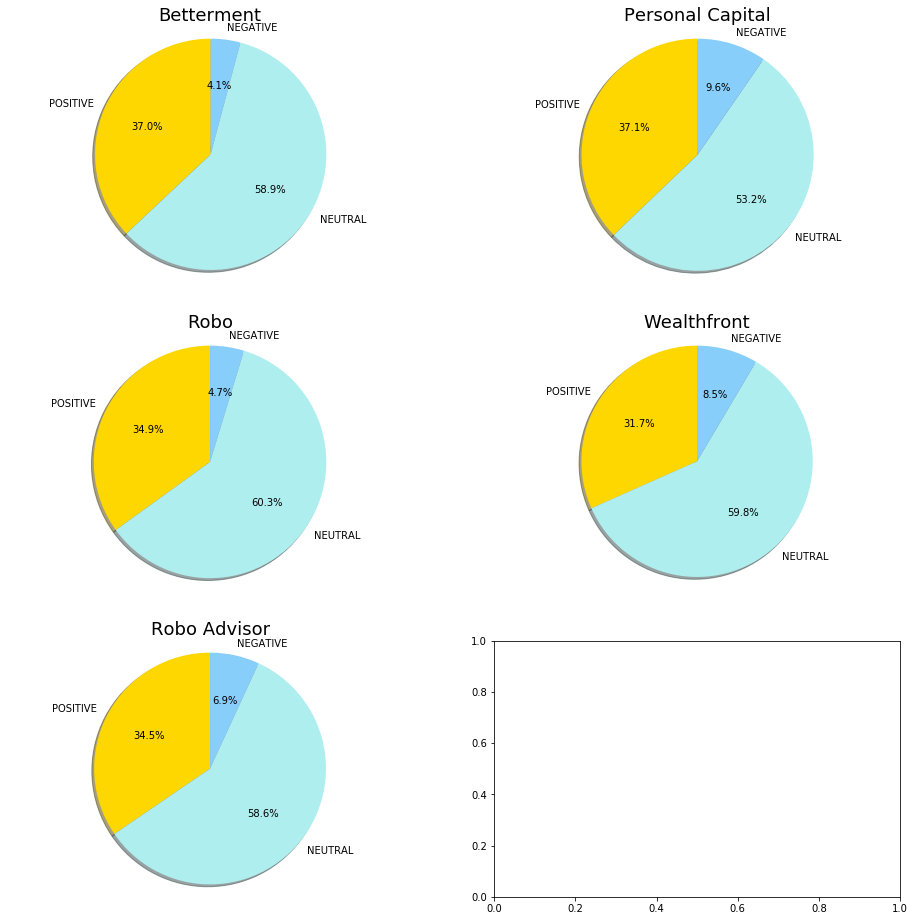

In [128]:
colors = ['gold','paleturquoise','lightskyblue']
fig, axs = plt.subplots(3, 2,figsize=(16,16))

axs[0,0].pie(sizes_be, labels=labels_be, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,0].axis('equal') 
axs[0,0].set_title("Betterment",fontsize = 18)

axs[0,1].pie(sizes_pc, labels=labels_pc, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,1].axis('equal') 
axs[0,1].set_title("Personal Capital",fontsize = 18)

axs[1,0].pie(sizes_ro, labels=labels_ro, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,0].axis('equal') 
axs[1,0].set_title("Robo",fontsize = 18)

axs[1,1].pie(sizes_we, labels=labels_we, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,1].axis('equal') 
axs[1,1].set_title("Wealthfront",fontsize = 18)

axs[2,0].pie(sizes_ra, labels=labels_ra, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[2,0].axis('equal') 
axs[2,0].set_title("Robo Advisor",fontsize = 18)

plt.show()

# Bank Brokerage

## Overview (without Wells Fargo)

In [129]:
start_month='2017-06'
end_month='2020-05'
DP=Data_Processor(start_month, end_month,
                  template=["result0623/Bank Brokerage/BOA/BOA",
                            "result0623/Bank Brokerage/JPMorgan/JPMorgan",
                            "result0623/Bank Brokerage/Merrill Lynch/MerrillLynch"])

DP.readdata()
print(DP.datanums())

([8384, 7616, 7935, 8168, 8442, 8792, 8376, 8978, 8934, 8510, 9412, 9691, 10377, 9096, 9411, 9914, 9868, 9651, 10755, 10088, 9996, 11427, 11435, 10779, 11644, 11867, 11758, 12615, 12423, 13053, 12198, 11685, 11828, 12660, 13515, 12505], 373786)


In [130]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_bb = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_bb = scores_month_bb.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [131]:
score_dist_bb = df["label"].value_counts().to_frame()
score_dist_bb.columns = ["count"]
score_dist_bb = score_dist_bb.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_bb["index"],
               y = score_dist_bb["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

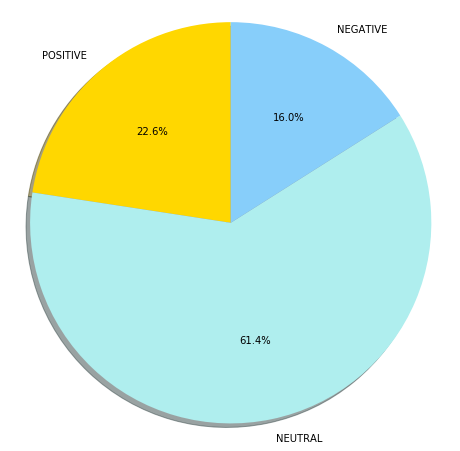

In [132]:
colors = ['gold','paleturquoise','lightskyblue']
labels_bb = list(score_dist_bb['index'].values)
sizes_bb = list(score_dist_bb['count'].values/sum(score_dist_bb['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_bb, labels=labels_bb, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

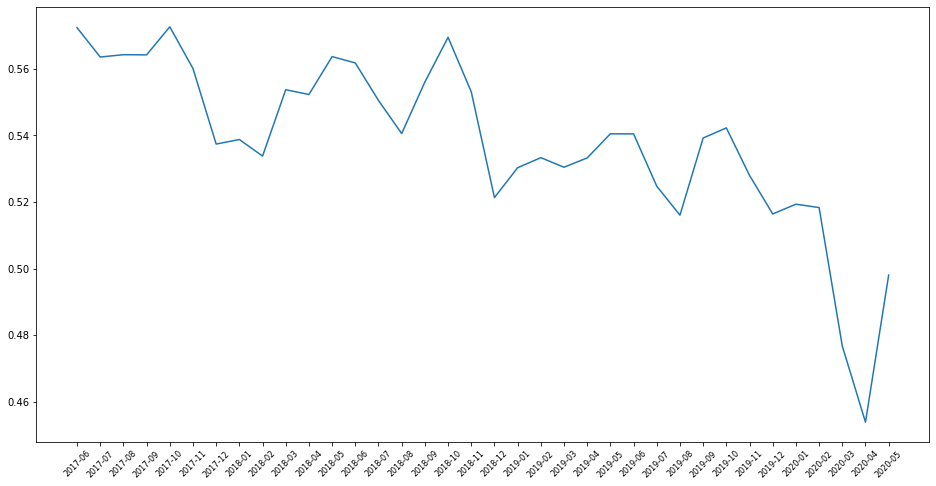

In [133]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_bb['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

## Overview (with Wells Fargo)

In [172]:
start_month='2017-06'
end_month='2020-05'
DP=Data_Processor(start_month, end_month,
                  template=["result0623/Bank Brokerage/BOA/BOA",
                            "result0623/Bank Brokerage/JPMorgan/JPMorgan",
                            "result0623/Bank Brokerage/Merrill Lynch/MerrillLynch",
                            "result0623/Bank Brokerage/Wells Fargo/WellsFargo"])

DP.readdata()
print(DP.datanums())

([13076, 12074, 12407, 13263, 13455, 14365, 13866, 14764, 14277, 14051, 15224, 15081, 16388, 15331, 15362, 16209, 16211, 15818, 16717, 16441, 16988, 17968, 18415, 17963, 19164, 19525, 18999, 19825, 19431, 20718, 19411, 18408, 18498, 20572, 21665, 20241], 602171)


In [173]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_bbwf = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_bbwf = scores_month_bbwf.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [174]:
score_dist_bbwf = df["label"].value_counts().to_frame()
score_dist_bbwf.columns = ["count"]
score_dist_bbwf = score_dist_bbwf.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_bbwf["index"],
               y = score_dist_bbwf["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

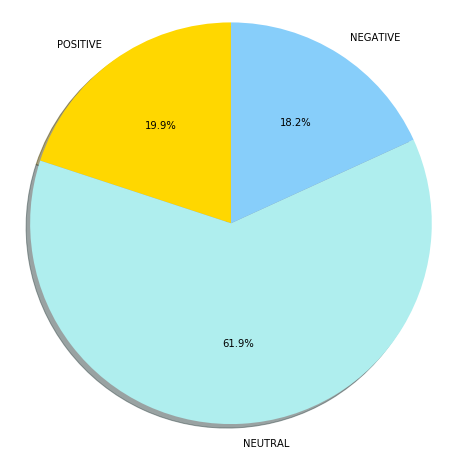

In [175]:
colors = ['gold','paleturquoise','lightskyblue']
labels_bbwf = list(score_dist_bbwf['index'].values)
sizes_bbwf = list(score_dist_bbwf['count'].values/sum(score_dist_bbwf['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_bbwf, labels=labels_bbwf, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

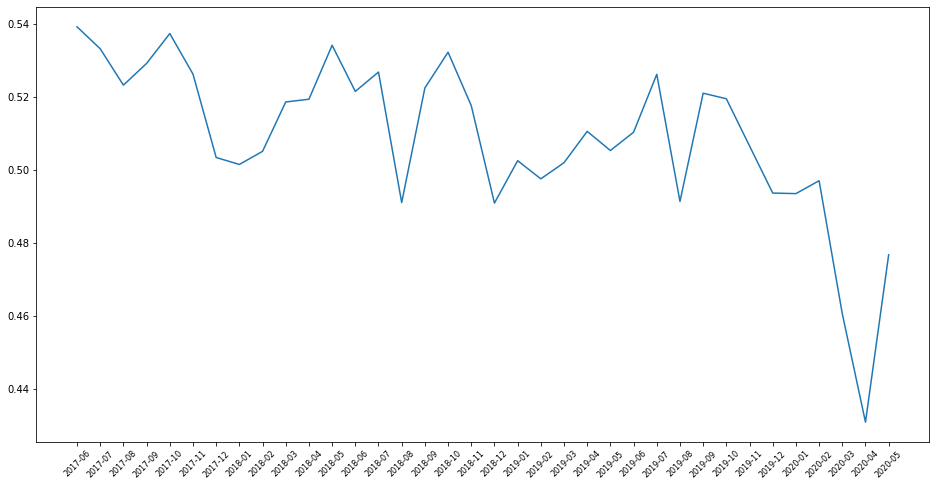

In [176]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_bbwf['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

## Each Company

### Merrill Lynch (BOA)

In [135]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Bank Brokerage/Merrill Lynch/MerrillLynch",
                            "result0623/Bank Brokerage/BOA/BOA"])
DP.readdata()
print(DP.datanums())

([5373, 4595, 4673, 4979, 5302, 5553, 5561, 5611, 5551, 5071, 6122, 6444, 6975, 6032, 6500, 6613, 6271, 6371, 7001, 6484, 6640, 7429, 7102, 6589, 7337, 7279, 7628, 8056, 7700, 8255, 8069, 7089, 7185, 7971, 8674, 7660], 237745)


In [136]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_mlboa = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_mlboa = scores_month_mlboa.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [137]:
score_dist_mlboa = df["label"].value_counts().to_frame()
score_dist_mlboa.columns = ["count"]
score_dist_mlboa = score_dist_mlboa.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_mlboa["index"],
               y = score_dist_mlboa["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

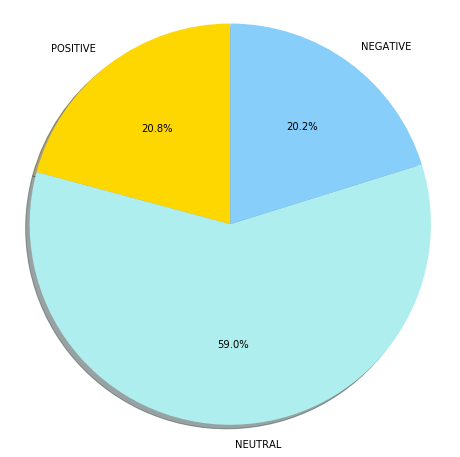

In [138]:
colors = ['gold','paleturquoise','lightskyblue']
labels_mlboa = list(score_dist_mlboa['index'].values)
sizes_mlboa = list(score_dist_mlboa['count'].values/sum(score_dist_mlboa['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_mlboa, labels=labels_mlboa, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

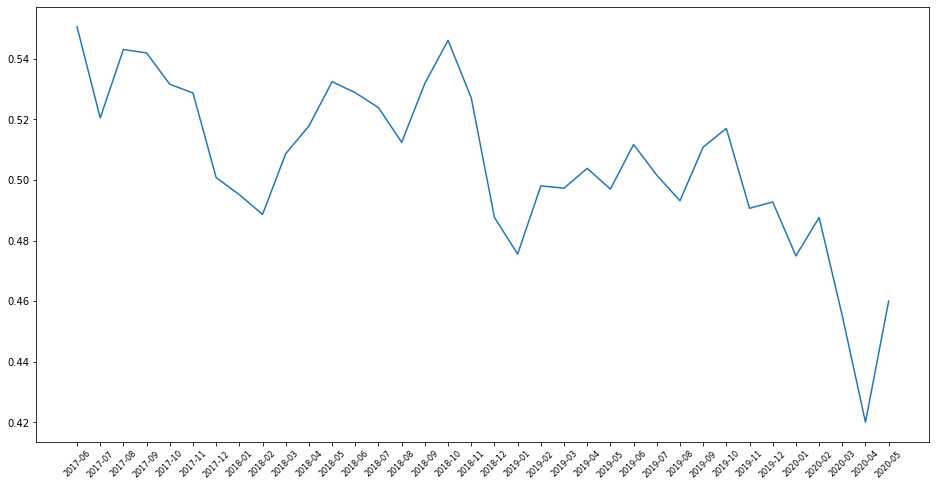

In [139]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_mlboa['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### JPMorgan

In [140]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Bank Brokerage/JPMorgan/JPMorgan"])
DP.readdata()
print(DP.datanums())

([3011, 3021, 3262, 3189, 3140, 3239, 2815, 3367, 3383, 3439, 3290, 3247, 3402, 3064, 2911, 3301, 3597, 3280, 3754, 3604, 3356, 3998, 4333, 4190, 4307, 4588, 4130, 4559, 4723, 4798, 4129, 4596, 4643, 4689, 4841, 4845], 136041)


In [141]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_jpm = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_jpm = scores_month_jpm.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [142]:
score_dist_jpm = df["label"].value_counts().to_frame()
score_dist_jpm.columns = ["count"]
score_dist_jpm = score_dist_jpm.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_jpm["index"],
               y = score_dist_jpm["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

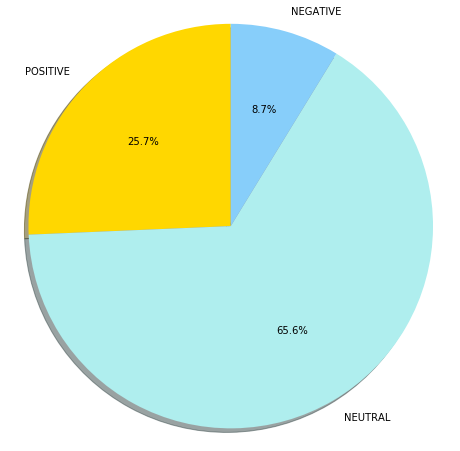

In [143]:
colors = ['gold','paleturquoise','lightskyblue']
labels_jpm = list(score_dist_jpm['index'].values)
sizes_jpm = list(score_dist_jpm['count'].values/sum(score_dist_jpm['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_jpm, labels=labels_jpm, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

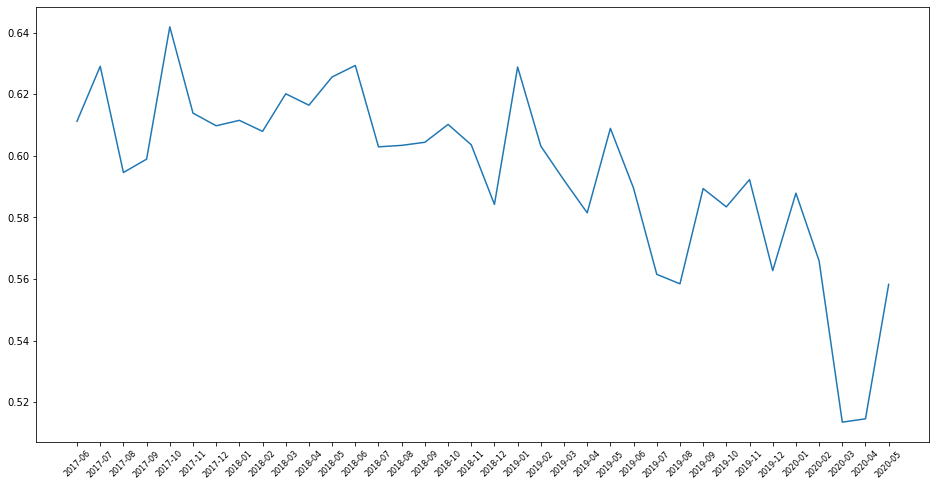

In [144]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_jpm['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Wells Fargo

In [177]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Bank Brokerage/Wells Fargo/WellsFargo"])
DP.readdata()
print(DP.datanums())

([4692, 4458, 4472, 5095, 5013, 5573, 5490, 5786, 5343, 5541, 5812, 5390, 6011, 6235, 5951, 6295, 6343, 6167, 5962, 6353, 6992, 6541, 6980, 7184, 7520, 7658, 7241, 7210, 7008, 7665, 7213, 6723, 6670, 7912, 8150, 7736], 228385)


In [178]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_wf = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_wf = scores_month_wf.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [179]:
score_dist_wf = df["label"].value_counts().to_frame()
score_dist_wf.columns = ["count"]
score_dist_wf = score_dist_wf.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_wf["index"],
               y = score_dist_wf["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

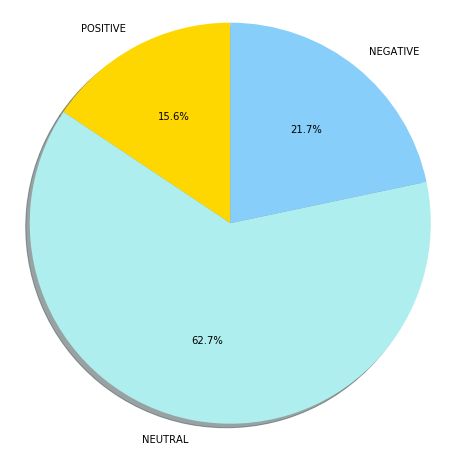

In [180]:
colors = ['gold','paleturquoise','lightskyblue']
labels_wf = list(score_dist_wf['index'].values)
sizes_wf = list(score_dist_wf['count'].values/sum(score_dist_wf['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_wf, labels=labels_wf, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

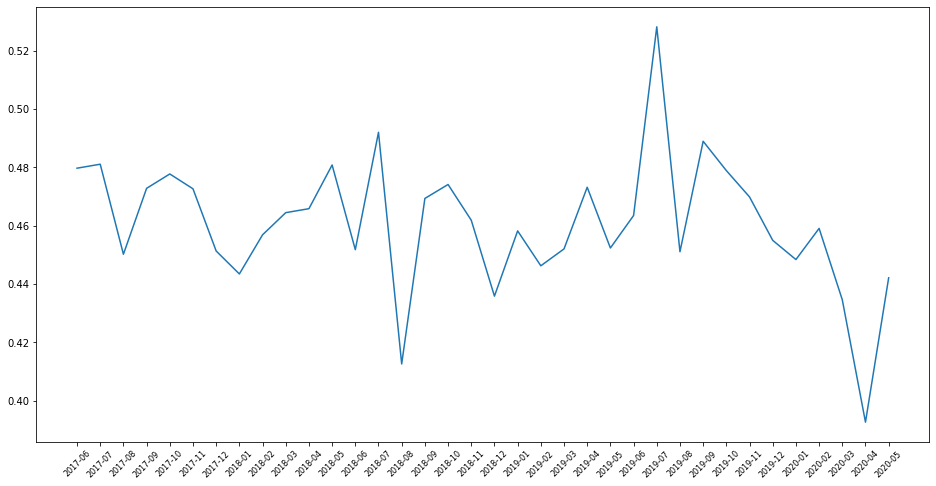

In [181]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_wf['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Comparasion

<function matplotlib.pyplot.show(*args, **kw)>

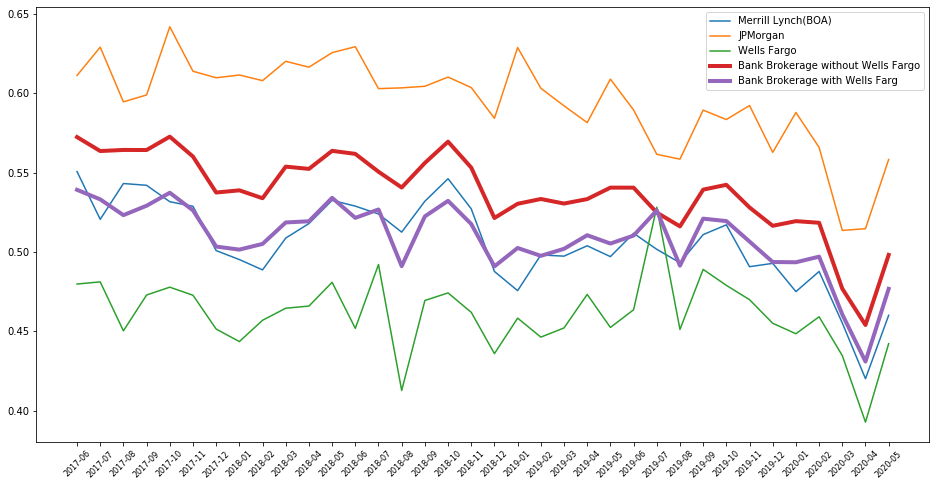

In [182]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_mlboa['avg_score'], label = 'Merrill Lynch(BOA)')
plt.plot(scores_month_jpm['avg_score'], label = 'JPMorgan')
plt.plot(scores_month_wf['avg_score'], label = 'Wells Fargo')
plt.plot(scores_month_bb['avg_score'], label = 'Bank Brokerage without Wells Fargo',linewidth=4)
plt.plot(scores_month_bbwf['avg_score'], label = 'Bank Brokerage with Wells Farg',linewidth=4)
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.legend()
plt.show

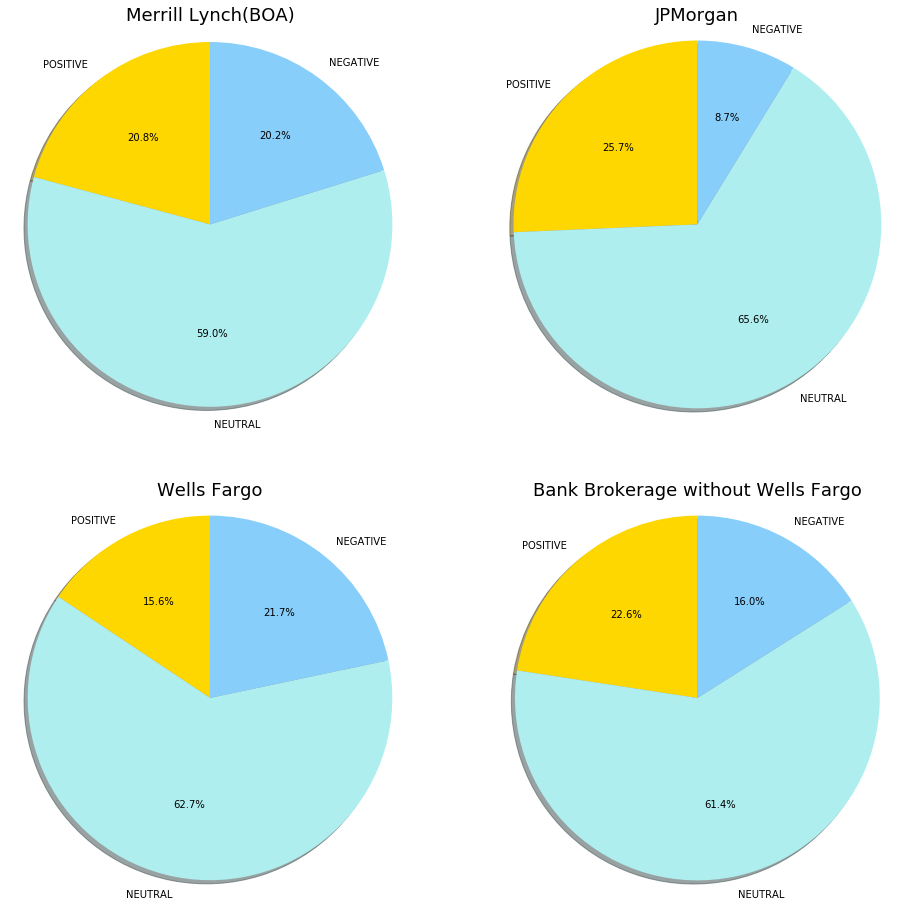

In [184]:
colors = ['gold','paleturquoise','lightskyblue']
fig, axs = plt.subplots(2, 2,figsize=(16,16))

axs[0,0].pie(sizes_mlboa, labels=labels_mlboa, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,0].axis('equal') 
axs[0,0].set_title("Merrill Lynch(BOA)",fontsize = 18)

axs[0,1].pie(sizes_jpm, labels=labels_jpm, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,1].axis('equal') 
axs[0,1].set_title("JPMorgan",fontsize = 18)

axs[1,0].pie(sizes_wf, labels=labels_wf, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,0].axis('equal') 
axs[1,0].set_title("Wells Fargo",fontsize = 18)

axs[1,1].pie(sizes_bb, labels=labels_bb, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,1].axis('equal') 
axs[1,1].set_title("Bank Brokerage without Wells Fargo",fontsize = 18)

plt.show()

# Full Brokerage

## Overview

In [188]:
start_month='2017-06'
end_month='2020-05'
DP=Data_Processor(start_month, end_month,
                  template=["result0623/Full Brokerage/Goldman_Sachs/Goldman_Sachs",
                            "result0623/Full Brokerage/Morgan_Stanley/Morgan_Stanley",
                            "result0623/Full Brokerage/UBS/UBS"])
DP.readdata()
print(DP.datanums())
DP.clean()
print(DP.datanums())

([8586, 9002, 9588, 10115, 9745, 11055, 10866, 9802, 9351, 8684, 8629, 9655, 9920, 8606, 9102, 9723, 9028, 8653, 9183, 8190, 8303, 9646, 9292, 9809, 9891, 8130, 8739, 10256, 9510, 10223, 9406, 9663, 10369, 10453, 10256, 11248], 342677)
([8586, 9002, 9588, 10115, 9745, 11055, 10866, 9802, 9351, 8684, 8629, 9655, 9920, 8606, 9102, 9723, 9028, 8653, 9183, 8190, 8303, 9646, 9292, 9809, 9891, 8130, 8739, 10256, 9510, 10223, 9406, 9663, 10369, 10453, 10256, 11248], 342677)


In [166]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_fb = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_fb = scores_month_fb.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [167]:
score_dist_fb = df["label"].value_counts().to_frame()
score_dist_fb.columns = ["count"]
score_dist_fb = score_dist_fb.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_fb["index"],
               y = score_dist_fb["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

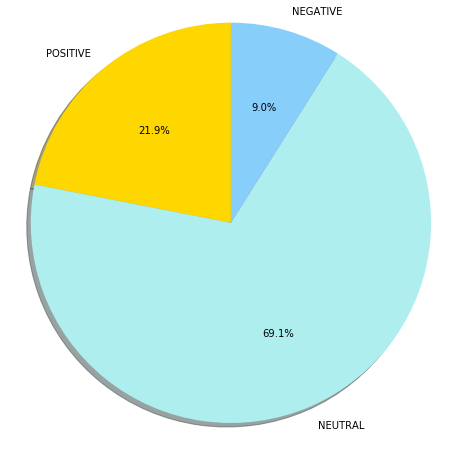

In [168]:
colors = ['gold','paleturquoise','lightskyblue']
labels_fb = list(score_dist_fb['index'].values)
sizes_fb = list(score_dist_fb['count'].values/sum(score_dist_fb['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_fb, labels=labels_fb, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

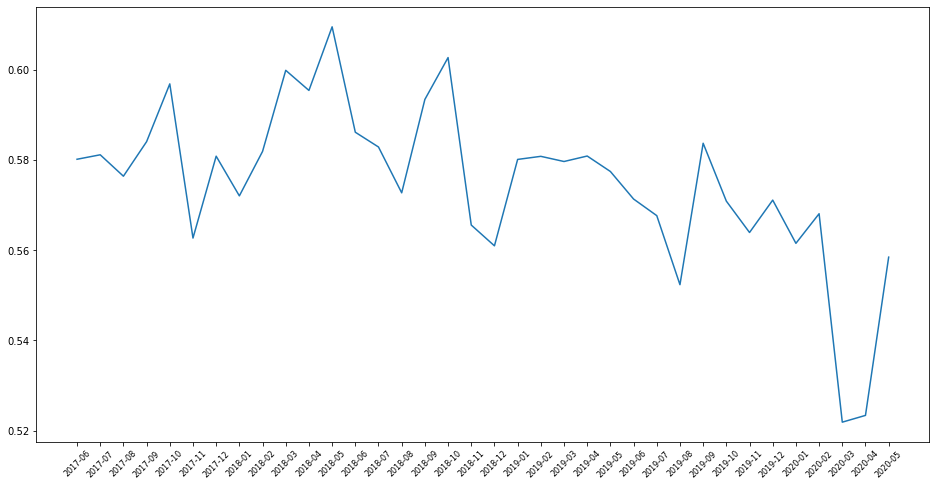

In [169]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_fb['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

## Each Company

### Goldman_Sachs

In [148]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Full Brokerage/Goldman_Sachs/Goldman_Sachs"])
DP.readdata()
print(DP.datanums())

([3671, 4119, 4222, 4497, 4097, 4071, 4294, 4410, 4184, 3662, 3712, 3579, 3966, 4175, 4242, 3851, 4130, 4101, 4241, 4176, 3854, 4413, 4506, 4411, 4338, 4275, 4779, 5040, 5145, 5544, 5015, 4765, 5571, 5523, 5439, 5347], 159365)


In [149]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_gs = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_gs = scores_month_gs.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [150]:
score_dist_gs = df["label"].value_counts().to_frame()
score_dist_gs.columns = ["count"]
score_dist_gs = score_dist_gs.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_gs["index"],
               y = score_dist_gs["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

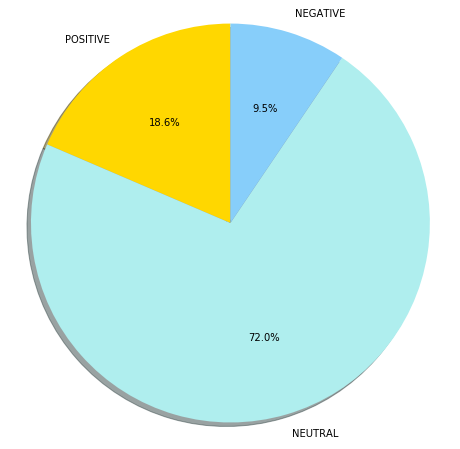

In [151]:
colors = ['gold','paleturquoise','lightskyblue']
labels_gs = list(score_dist_gs['index'].values)
sizes_gs = list(score_dist_gs['count'].values/sum(score_dist_gs['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_gs, labels=labels_gs, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

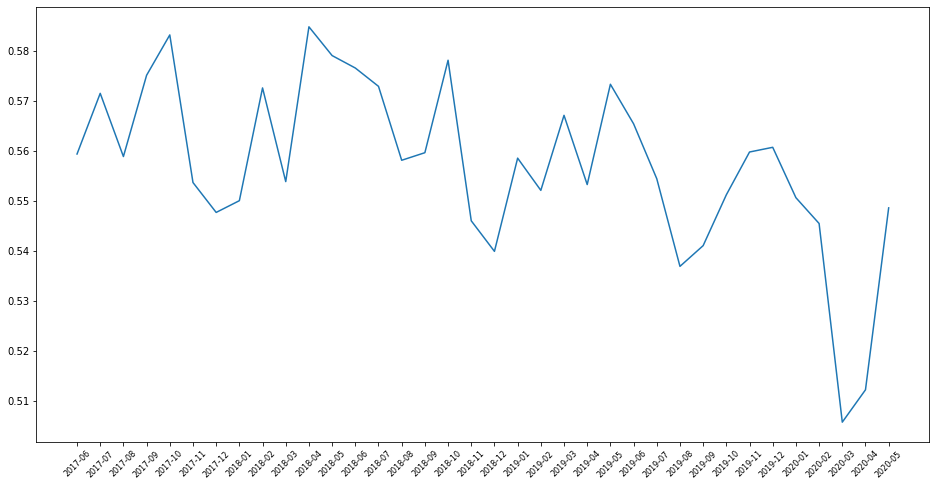

In [152]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_gs['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Morgan_Stanley

In [153]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Full Brokerage/Morgan_Stanley/Morgan_Stanley"])
DP.readdata()
print(DP.datanums())

([2619, 2982, 3456, 3206, 3040, 3505, 3968, 3319, 2931, 3106, 2701, 3589, 3197, 2540, 2877, 3609, 3016, 2345, 2926, 2228, 2508, 3237, 2853, 3386, 3270, 1997, 2405, 2934, 2573, 2623, 2583, 2846, 2890, 3152, 3081, 3836], 107334)


In [154]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_ms = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_ms = scores_month_ms.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [155]:
score_dist_ms = df["label"].value_counts().to_frame()
score_dist_ms.columns = ["count"]
score_dist_ms = score_dist_ms.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_ms["index"],
               y = score_dist_ms["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

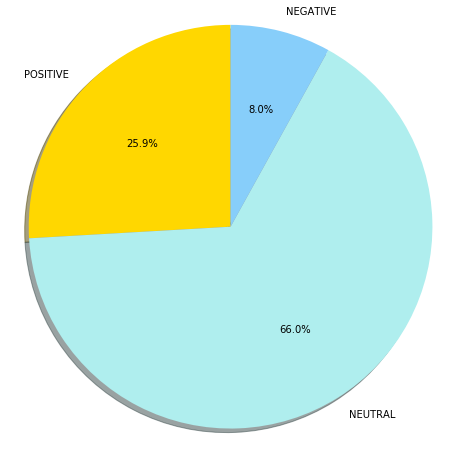

In [156]:
colors = ['gold','paleturquoise','lightskyblue']
labels_ms = list(score_dist_ms['index'].values)
sizes_ms = list(score_dist_ms['count'].values/sum(score_dist_ms['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_ms, labels=labels_ms, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

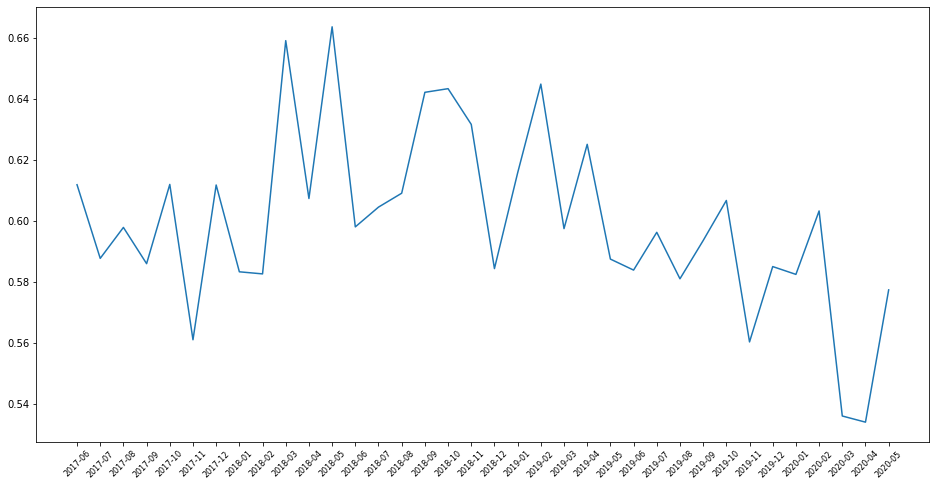

In [157]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_ms['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### UBS

In [159]:
start_month='2017-06'
end_month='2020-05'

DP=Data_Processor(start_month, end_month,
                  template=["result0623/Full Brokerage/UBS/UBS"])
DP.readdata()
print(DP.datanums())

([2296, 1901, 1910, 2412, 2608, 3479, 2604, 2073, 2236, 1916, 2216, 2487, 2757, 1891, 1983, 2263, 1882, 2207, 2016, 1786, 1941, 1996, 1933, 2012, 2283, 1858, 1555, 2282, 1792, 2056, 1808, 2052, 1908, 1778, 1736, 2065], 75978)


In [160]:
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']
dl = datelist(start_month, end_month)
df = pd.DataFrame(columns=col)
scores_month_ubs = pd.DataFrame(columns=('time', 'avg_score'))
for i in range(len(DP.data)):
    d = pd.DataFrame(DP.data[i],columns=col)
    d['month_avg_score'] = np.average(d['score'])
    df = df.append(d)
    scores_month_ubs = scores_month_ubs.append(pd.DataFrame({'time':[dl[i]], 'avg_score':[np.average(d['score'])]}),ignore_index=True)

In [161]:
score_dist_ubs = df["label"].value_counts().to_frame()
score_dist_ubs.columns = ["count"]
score_dist_ubs = score_dist_ubs.reset_index().sort_values(by = "index" ,ascending = False)

layout = go.Layout(dict(title = "Scores distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     gridwidth = 2),
                        )
                  )

trace = go.Bar(x = score_dist_ubs["index"],
               y = score_dist_ubs["count"],
               marker = dict(line = dict(width = 1,color = "black"),
                             color = "gold")
              )


fig = go.Figure(data = [trace],layout = layout)
py.offline.iplot(fig)

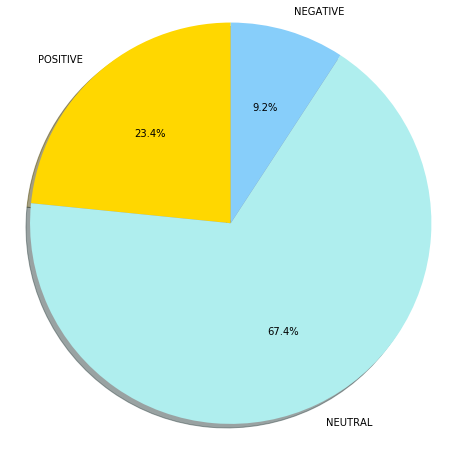

In [162]:
colors = ['gold','paleturquoise','lightskyblue']
labels_ubs = list(score_dist_ubs['index'].values)
sizes_ubs = list(score_dist_ubs['count'].values/sum(score_dist_ubs['count'].values)*100)
#explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes_ubs, labels=labels_ubs, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

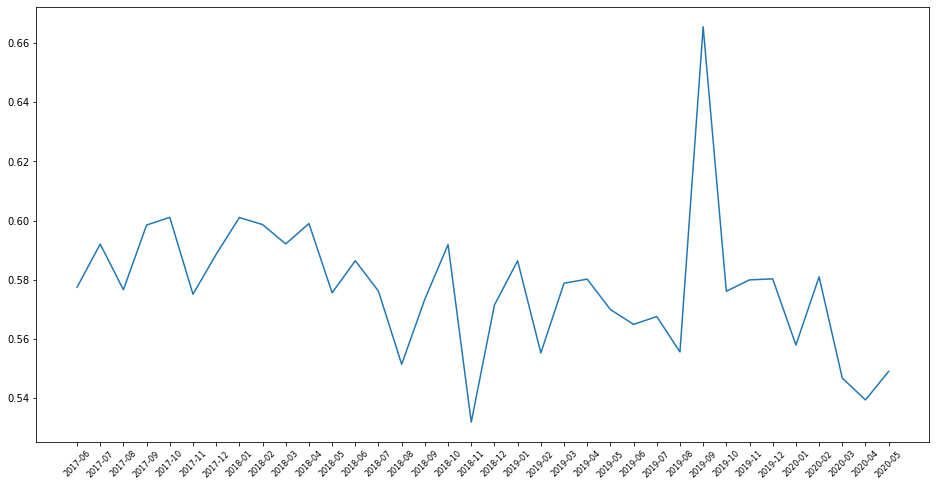

In [163]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_ubs['avg_score'])
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.show

### Comparasion

<function matplotlib.pyplot.show(*args, **kw)>

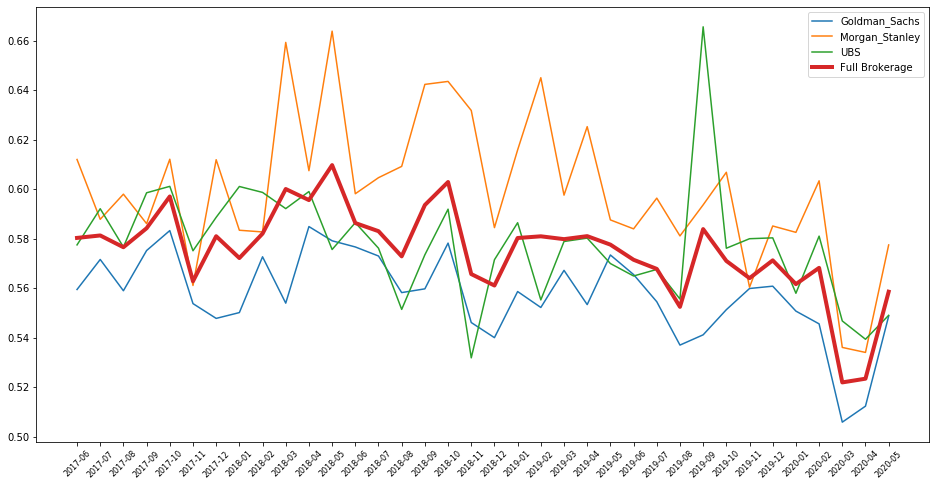

In [170]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_gs['avg_score'], label = 'Goldman_Sachs')
plt.plot(scores_month_ms['avg_score'], label = 'Morgan_Stanley')
plt.plot(scores_month_ubs['avg_score'], label = 'UBS')
plt.plot(scores_month_fb['avg_score'], label = 'Full Brokerage',linewidth=4)
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.legend()
plt.show

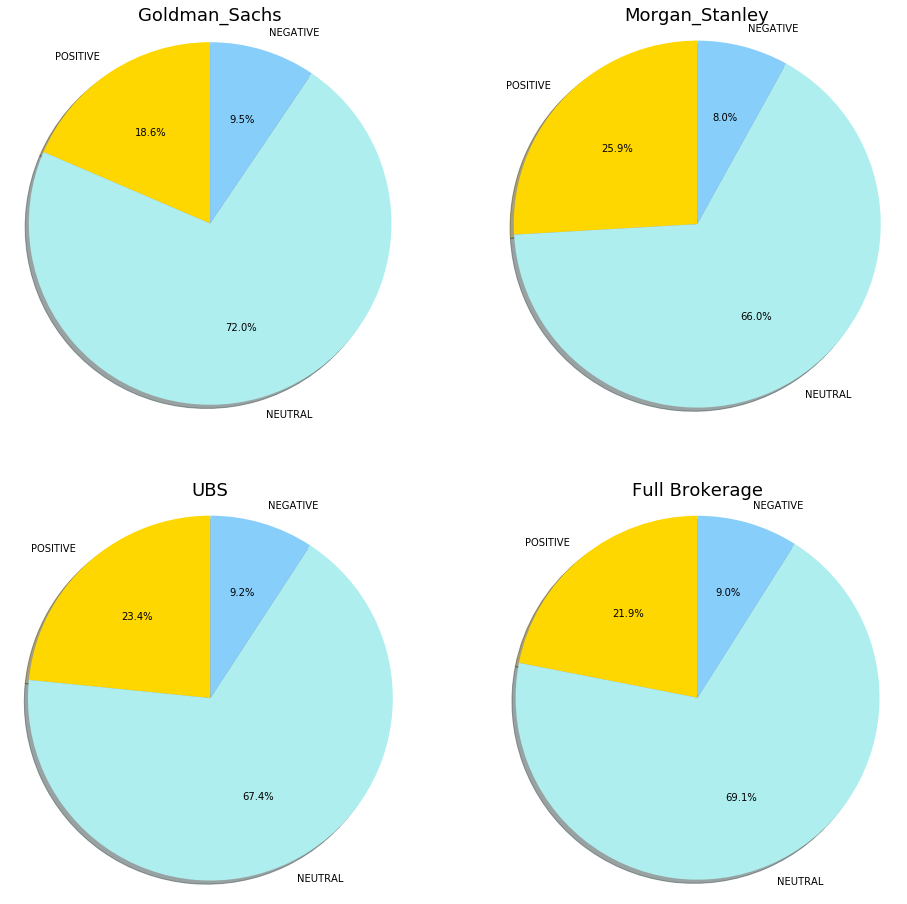

In [171]:
colors = ['gold','paleturquoise','lightskyblue']
fig, axs = plt.subplots(2, 2,figsize=(16,16))

axs[0,0].pie(sizes_gs, labels=labels_gs, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,0].axis('equal') 
axs[0,0].set_title("Goldman_Sachs",fontsize = 18)

axs[0,1].pie(sizes_ms, labels=labels_ms, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,1].axis('equal') 
axs[0,1].set_title("Morgan_Stanley",fontsize = 18)

axs[1,0].pie(sizes_ubs, labels=labels_ubs, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,0].axis('equal') 
axs[1,0].set_title("UBS",fontsize = 18)

axs[1,1].pie(sizes_fb, labels=labels_fb, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,1].axis('equal') 
axs[1,1].set_title("Full Brokerage",fontsize = 18)

plt.show()

# Comparasion

<function matplotlib.pyplot.show(*args, **kw)>

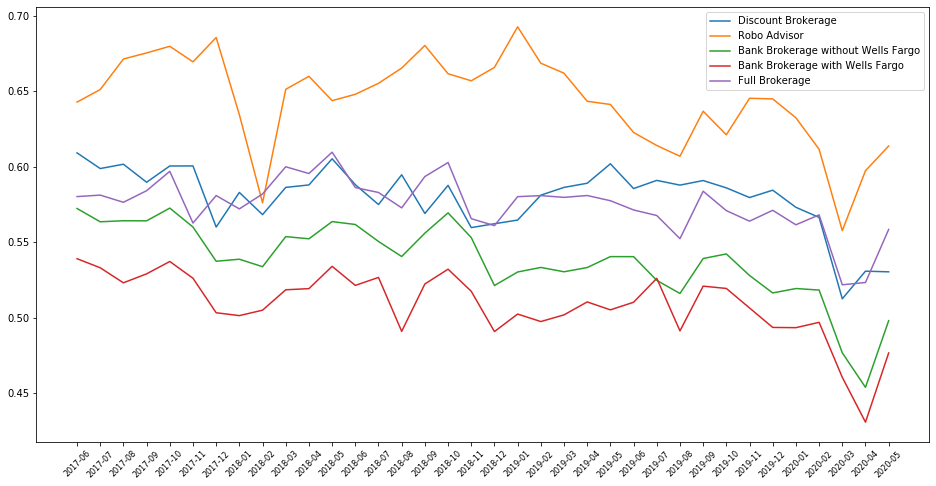

In [185]:
plt.figure(figsize=(16,8))
plt.plot(scores_month_db['avg_score'], label = 'Discount Brokerage')
plt.plot(scores_month_ra['avg_score'], label = 'Robo Advisor')
plt.plot(scores_month_bb['avg_score'], label = 'Bank Brokerage without Wells Fargo')
plt.plot(scores_month_bbwf['avg_score'], label = 'Bank Brokerage with Wells Fargo')
plt.plot(scores_month_fb['avg_score'], label = 'Full Brokerage')
plt.xticks(range(0,len(dl)), dl)
plt.tick_params(axis='x', labelsize=8) 
plt.xticks(rotation=45) 
plt.legend()
plt.show

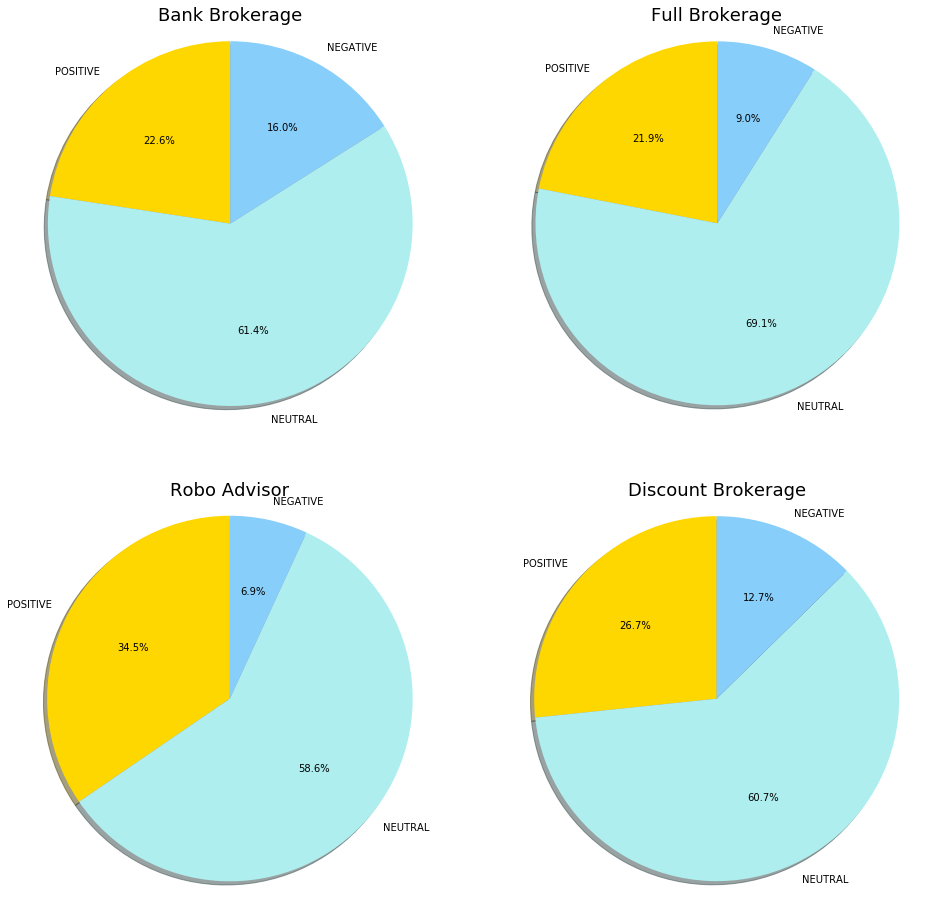

In [186]:
colors = ['gold','paleturquoise','lightskyblue']
fig, axs = plt.subplots(2, 2,figsize=(16,16))

axs[0,0].pie(sizes_bb, labels=labels_bb, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,0].axis('equal') 
axs[0,0].set_title("Bank Brokerage",fontsize = 18)

axs[0,1].pie(sizes_fb, labels=labels_fb, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0,1].axis('equal') 
axs[0,1].set_title("Full Brokerage",fontsize = 18)

axs[1,0].pie(sizes_ra, labels=labels_ra, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,0].axis('equal') 
axs[1,0].set_title("Robo Advisor",fontsize = 18)

axs[1,1].pie(sizes_db, labels=labels_db, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1,1].axis('equal') 
axs[1,1].set_title("Discount Brokerage",fontsize = 18)


plt.show()